# Importing Libraries

In [1]:
!pip install xgboost
!pip install MultiColumnLabelEncoder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from MultiColumnLabelEncoder import MultiColumnLabelEncoder
from xgboost import XGBClassifier
from xgboost import plot_tree
from xgboost import plot_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


%matplotlib inline

# Reading Data

In [2]:
df = pd.read_csv("dementia_dataset.csv")
df.sort_values(by=["Group"])

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
245,OAS2_0118,OAS2_0118_MR1,Converted,1,0,F,R,67,14,4.0,30.0,0.0,1508,0.794,1.164
81,OAS2_0041,OAS2_0041_MR1,Converted,1,0,F,R,71,16,1.0,27.0,0.0,1289,0.771,1.362
295,OAS2_0144,OAS2_0144_MR1,Converted,1,0,M,R,77,16,1.0,30.0,0.0,1704,0.716,1.030
261,OAS2_0127,OAS2_0127_MR1,Converted,1,0,M,R,79,18,1.0,29.0,0.0,1644,0.729,1.067
262,OAS2_0127,OAS2_0127_MR2,Converted,2,851,M,R,81,18,1.0,29.0,0.5,1654,0.720,1.061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,OAS2_0077,OAS2_0077_MR2,Nondemented,2,1393,M,R,73,16,2.0,29.0,0.0,1931,0.722,0.909
168,OAS2_0078,OAS2_0078_MR1,Nondemented,1,0,M,R,89,16,1.0,28.0,0.0,1631,0.674,1.076
169,OAS2_0078,OAS2_0078_MR2,Nondemented,2,441,M,R,91,16,1.0,28.0,0.0,1640,0.670,1.070
152,OAS2_0070,OAS2_0070_MR4,Nondemented,4,1870,M,R,85,17,1.0,30.0,0.0,1724,0.704,1.018


# Data Visualisation

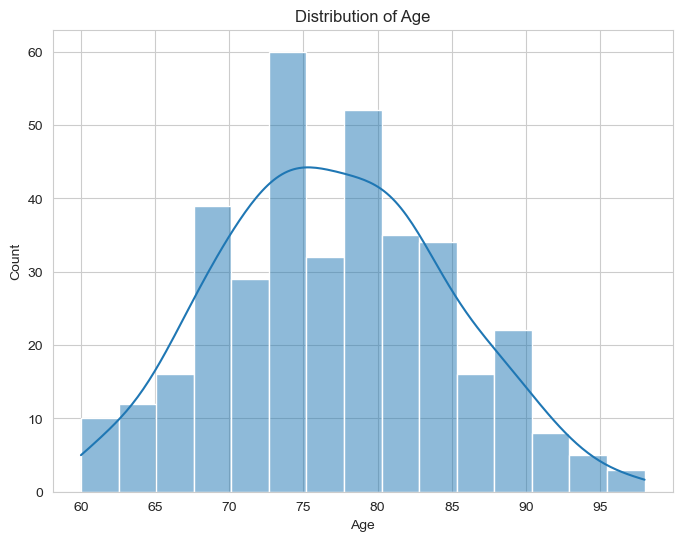

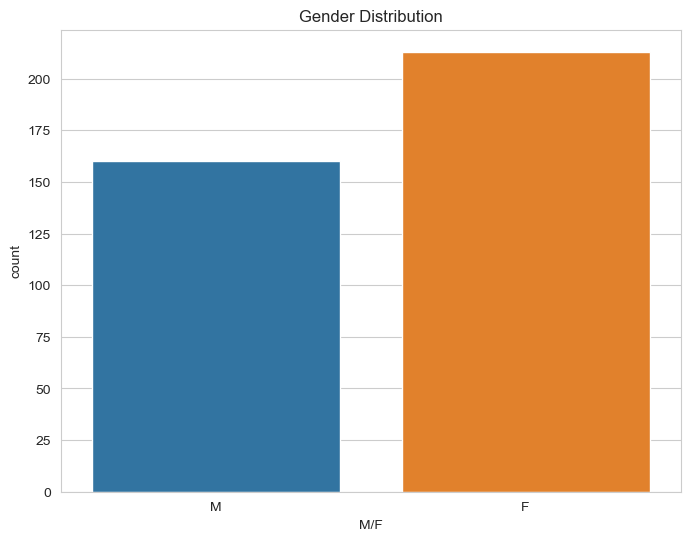

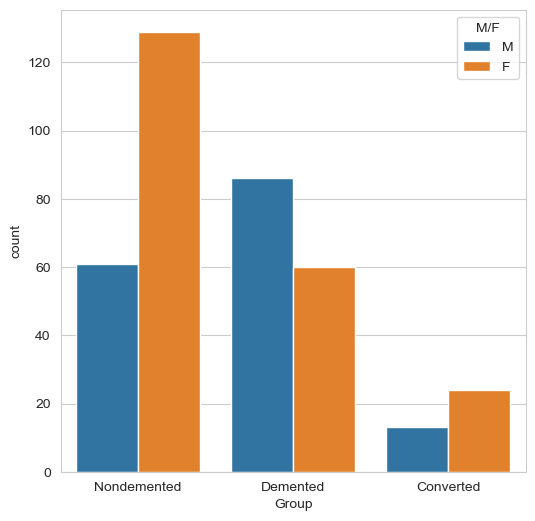

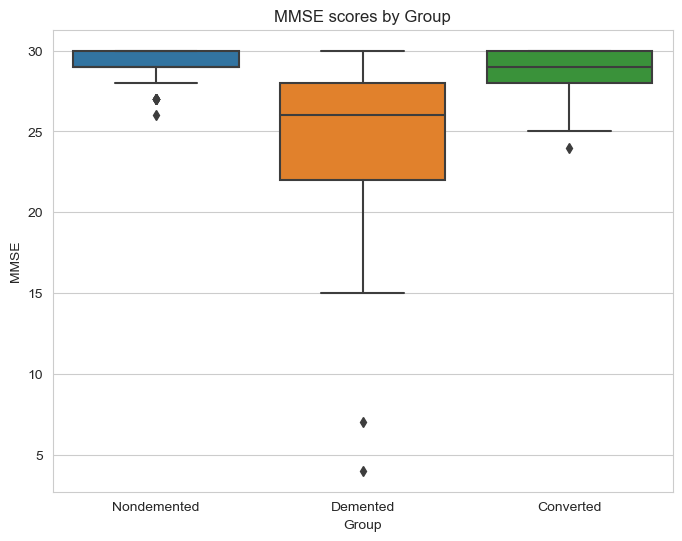

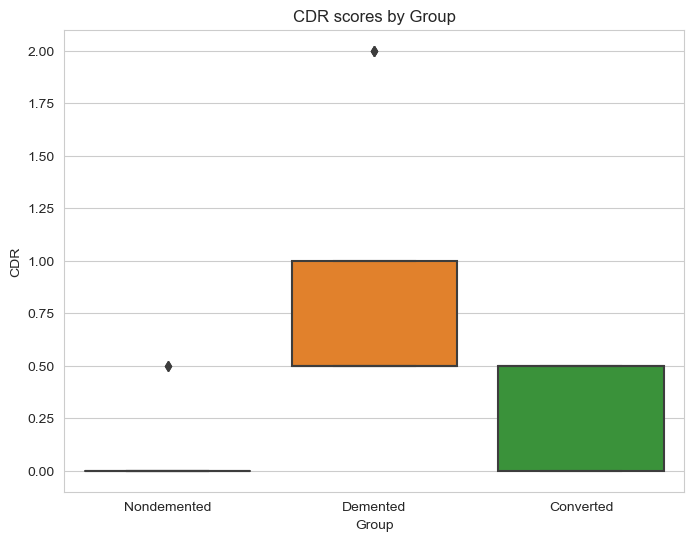

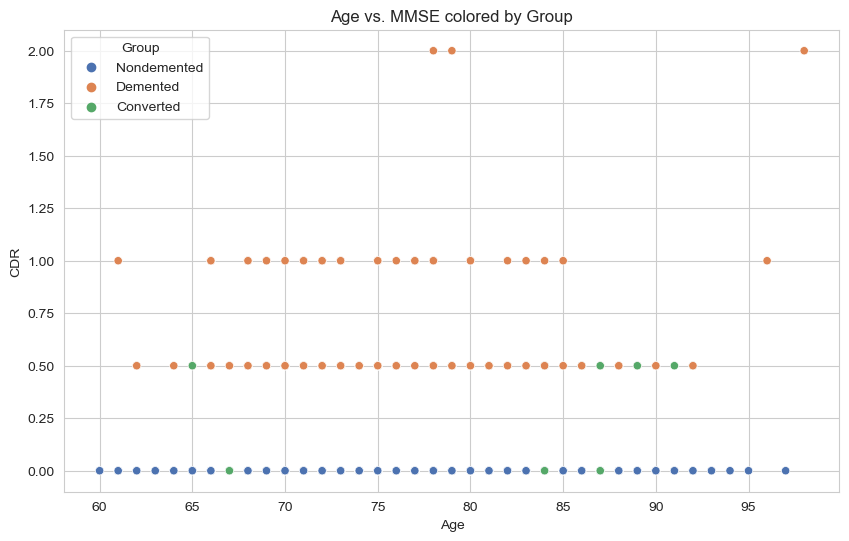

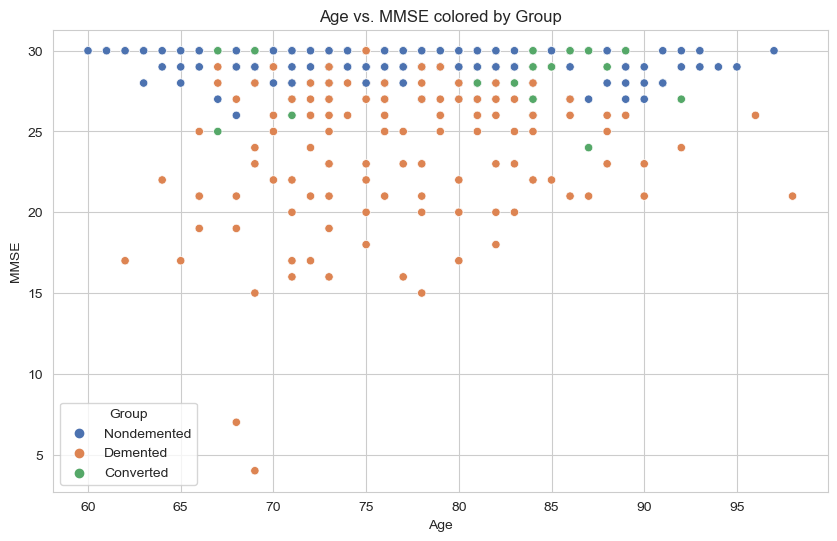

In [3]:
# Visualization settings
sns.set_style("whitegrid")

# a. Distribution of Age
plt.figure(figsize=(8, 6))
sns.histplot(df['Age'], kde=True, bins=15)
plt.title("Distribution of Age")
plt.savefig("age_distribution.png")
plt.show()


    # b. Gender Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='M/F')
plt.title("Gender Distribution")
plt.savefig("gender_distribution.png")
plt.show()

plt.figure ( figsize= (6,6) )
sns.countplot ( x = "Group", hue="M/F", data = df )
plt.savefig("gender_by_group.png")
plt.show()

# d. MMSE scores by Group
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Group', y='MMSE')
plt.title("MMSE scores by Group")
plt.savefig("mmse_by_group.png")
plt.show()

# d. CDR scores by Group
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Group', y='CDR')
plt.title("CDR scores by Group")
plt.savefig("cdr_by_group.png")
plt.show()

# e. Age vs. CDR
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='CDR', hue='Group', palette="deep")
plt.title("Age vs. MMSE colored by Group")
plt.savefig("age_vs_cdr.png")
plt.show()

# e. Age vs. MMSE
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='MMSE', hue='Group', palette="deep")
plt.title("Age vs. MMSE colored by Group")
plt.savefig("age_vs_mmse.png")
plt.show()


# Data Pre-processing

In [4]:
# Remove IDs from dataset
df.drop(["Subject ID", "MRI ID", "Hand"], axis=1, inplace=True)
df.head(5)

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,1,0,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,1,0,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,2,560,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,3,1895,M,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [5]:
column_names = list(df.columns.values)
def check_nan(column_names):
    for column in column_names:
        print("column: {0} --> {1}".format(column, df[column].isnull().sum()))
        
check_nan(column_names)
# replace null values with 0
df.fillna(0,inplace=True)

column: Group --> 0
column: Visit --> 0
column: MR Delay --> 0
column: M/F --> 0
column: Age --> 0
column: EDUC --> 0
column: SES --> 19
column: MMSE --> 2
column: CDR --> 0
column: eTIV --> 0
column: nWBV --> 0
column: ASF --> 0


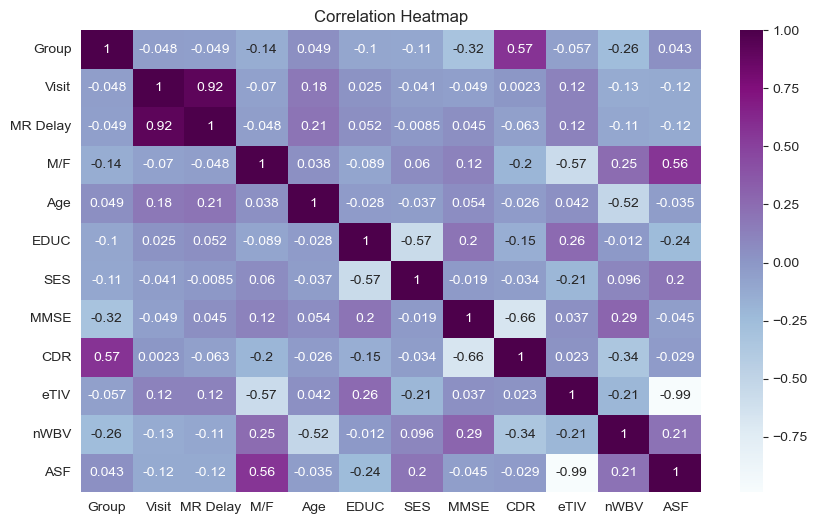

In [6]:
# visualise correlation among data variables
Mcle = MultiColumnLabelEncoder()
encoded_data = Mcle.fit_transform(df)
corr=encoded_data.corr()
# plot the correlation
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True,cmap='BuPu')
plt.title("Correlation Heatmap")
plt.savefig("correlation_heatmap.png")

# Prepare data for prediction model

In [7]:
# split dataset
X = df.iloc[:, 1:]
y = df.iloc[:,0]
# encode categorical values in X and y datasets
Mcle = MultiColumnLabelEncoder()
encoded_x = Mcle.fit_transform(X)
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
encoded_y = label_encoder.transform(y)

# Train and Test data split

In [8]:
seed = 0
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(encoded_x, encoded_y, 
                                                    test_size = test_size,
                                                    random_state = seed)
eval_set = [(X_train, y_train), (X_test, y_test)]

# XGBoost Model



In [9]:
np.random.seed(0)

def model_param_selection(model, X, y, param_grid, nfolds):
    """Function to perform grid search."""
    
    # Set up the grid search
    grid_search = GridSearchCV(model, param_grid, cv=nfolds, verbose=10, n_jobs=-1)
    best_model = grid_search.fit(X, y)
    
    # Return the best parameters from the grid search
    return best_model, grid_search.best_params_, grid_search.best_score_

# Define the parameter values to be searched for XGBoost
param_grid_xgb = {
    'max_depth': [2, 3, 4],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'colsample_bylevel': [0.7, 0.8]
}

Kfold = 5
model_xgb = XGBClassifier(random_state=0)
best_model_xgb, best_params_xgb, acc_xgb = model_param_selection(model_xgb, encoded_x, encoded_y, param_grid_xgb, Kfold)

std_xgb = best_model_xgb.cv_results_['std_test_score'][best_model_xgb.best_index_]

print("Best Params: ", best_params_xgb)
print("Best Score:", acc_xgb)
print("Best Score std:", std_xgb)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Params:  {'colsample_bylevel': 0.8, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.7}
Best Score: 0.9143063063063064
Best Score std: 0.019669734772833153


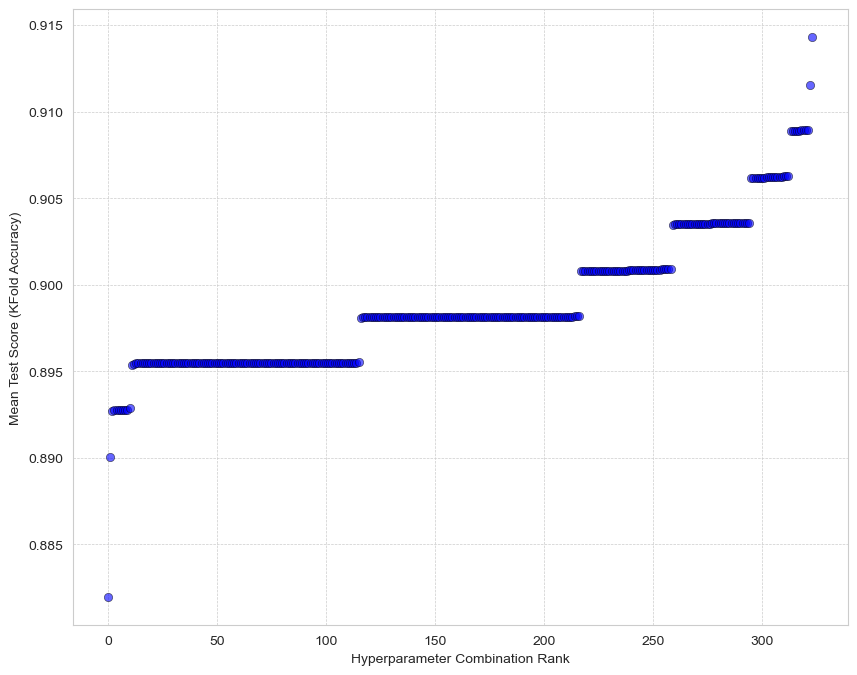

In [10]:
# Extract mean test scores
mean_test_scores = best_model_xgb.cv_results_['mean_test_score']

# Sort the mean test scores in ascending order and get their indices
sorted_indices = np.argsort(mean_test_scores)
sorted_scores = mean_test_scores[sorted_indices]

# Create positions for each hyperparameter combination
positions = np.arange(len(sorted_scores))

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(positions, sorted_scores, color='blue', alpha=0.6, edgecolors="k", linewidth=0.5)
plt.xlabel('Hyperparameter Combination Rank')
plt.ylabel('Mean Test Score (KFold Accuracy)')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig("xgboost_scatter_plot.png")
plt.show()


In [11]:
# Extract all parameter sets for XGBoost
params_sets_xgb = best_model_xgb.cv_results_['params']

# Extract mean test scores for XGBoost
mean_test_scores_xgb = best_model_xgb.cv_results_['mean_test_score']

# Sort the mean test scores in ascending order and get their indices
sorted_indices_xgb = np.argsort(mean_test_scores_xgb)

# Get parameters and accuracy for lowest, medium, and highest kfold accuracy for XGBoost
lowest_params_xgb = params_sets_xgb[sorted_indices_xgb[0]]
middle_params_xgb = params_sets_xgb[sorted_indices_xgb[len(sorted_indices_xgb) // 2]]  # Choose the middle index
highest_params_xgb = params_sets_xgb[sorted_indices_xgb[-1]]  # The last index corresponds to the best parameters
lowest_acc_xgb = mean_test_scores_xgb[sorted_indices_xgb[0]]
middle_acc_xgb = mean_test_scores_xgb[sorted_indices_xgb[len(sorted_indices_xgb) // 2]]
highest_acc_xgb = mean_test_scores_xgb[sorted_indices_xgb[-1]]

# Function to print the table for XGBoost
def print_params_table_xgb(lowest, middle, highest, lowest_acc, middle_acc, highest_acc):
    # Print the header
    print("{:<25} {:<25} {:<25} {:<25}".format('Parameter/Metric', 'Lowest', 'Middle', 'Highest'))
    print('-' * 100)
    
    # Print kfold accuracy values for XGBoost
    print("{:<25} {:<25.5f} {:<25.5f} {:<25.5f}".format('KFold Accuracy', lowest_acc, middle_acc, highest_acc))
    print('-' * 100)
    
    # Print parameter values for XGBoost
    for key in lowest:
        print("{:<25} {:<25} {:<25} {:<25}".format(key, str(lowest[key]), str(middle[key]), str(highest[key])))

print_params_table_xgb(lowest_params_xgb, middle_params_xgb, highest_params_xgb, lowest_acc_xgb, middle_acc_xgb, highest_acc_xgb)


Parameter/Metric          Lowest                    Middle                    Highest                  
----------------------------------------------------------------------------------------------------
KFold Accuracy            0.88195                   0.89816                   0.91431                  
----------------------------------------------------------------------------------------------------
colsample_bylevel         0.8                       0.8                       0.8                      
colsample_bytree          0.9                       0.9                       0.9                      
learning_rate             0.1                       0.01                      0.1                      
max_depth                 2                         4                         4                        
n_estimators              150                       100                       100                      
subsample                 0.9                       0.7               

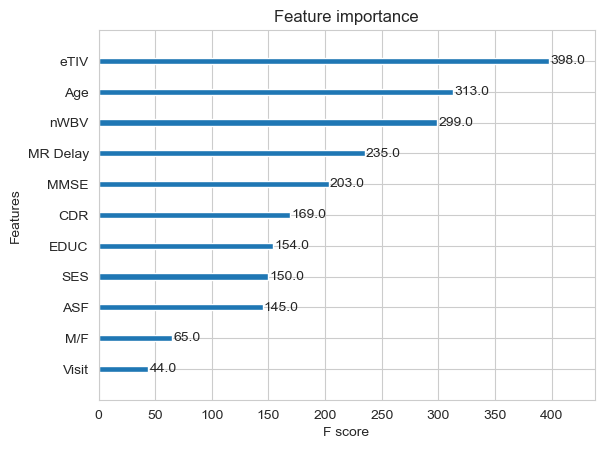

In [12]:
# visualise feature importance in xgboost
plot_importance(best_model_xgb.best_estimator_)
plt.savefig("xgboost_feature_importance_plot.png")
plt.show()

['Visit', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
[0.0306778  0.04571189 0.04091523 0.03250865 0.039931   0.0468624
 0.13573292 0.5138965  0.03640966 0.03339808 0.04395577]


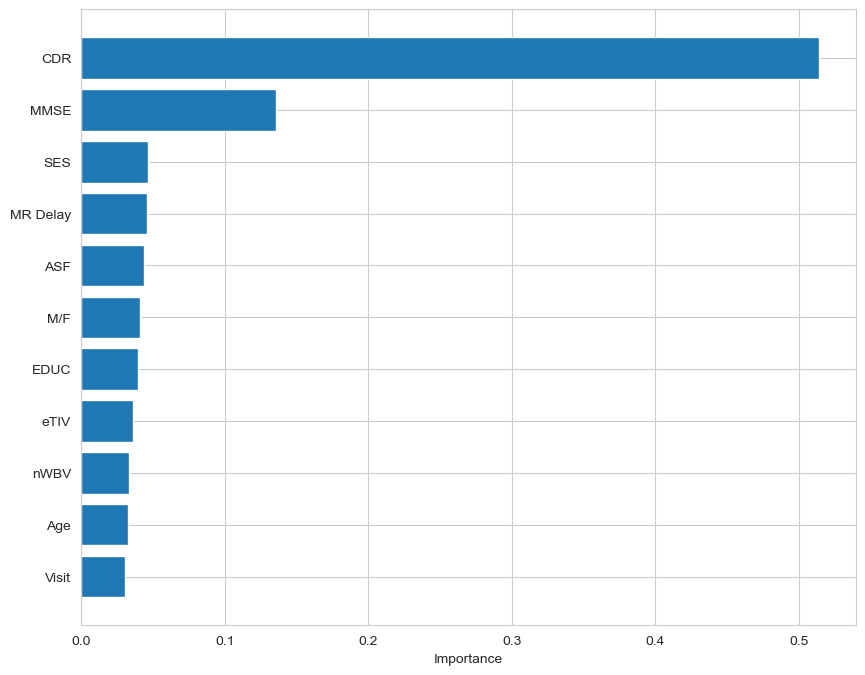

In [13]:
# Assuming encoded_x is a DataFrame and its columns are feature names
feature_names = encoded_x.columns.tolist()


# Get feature importances from XGBoost
importances = best_model_xgb.best_estimator_.feature_importances_
print(feature_names)
print(importances)

# Sort the feature importances
indices = np.argsort(importances)

# Get sorted feature names
sorted_feature_names = [feature_names[i] for i in indices]

# Plot
plt.figure(figsize=(10, 8))

plt.barh(sorted_feature_names, importances[indices], align="center")
plt.xlabel("Importance")
plt.savefig("xgboost_feature_importance_plot.png")
plt.show()


# Logistic Regression Model



In [14]:
np.random.seed(0)

def model_param_selection(model, X, y, param_grid, nfolds):
    """Function to perform grid search."""
    
    # Set up the grid search
    grid_search = GridSearchCV(model, param_grid, cv=nfolds, verbose=10, n_jobs=-1)
    best_model = grid_search.fit(X, y)
    
    # Return the best parameters from the grid search
    return best_model, grid_search.best_params_, grid_search.best_score_

# Define the parameter values to be searched for Logistic Regression
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'tol': [1e-4, 1e-3, 1e-5],
    'C': [0.1, 0.5, 1, 5, 10],
    'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
    'max_iter': [50, 100, 150, 200]
}

Kfold = 5
model_lr = LogisticRegression(multi_class='auto', random_state=0)
best_model_lr, best_params_lr, acc_lr = model_param_selection(model_lr, encoded_x, encoded_y, param_grid_lr, Kfold)

std_lr = best_model_lr.cv_results_['std_test_score'][best_model_lr.best_index_]

print("Best Params: ", best_params_lr)
print("Best Score:", acc_lr)
print("Best Score std:", std_lr)


Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Best Params:  {'C': 5, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.0001}
Best Score: 0.9089009009009009
Best Score std: 0.012792843547672461


C:\Users\alfre\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
900 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\alfre\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alfre\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alfre\anaconda3\Lib\site-packages\sklearn\linear_model

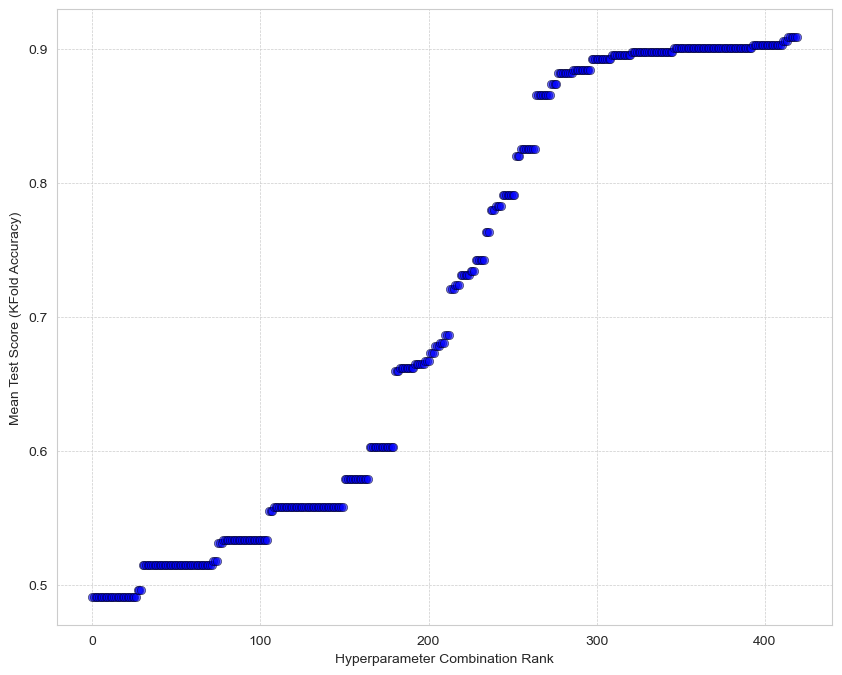

In [15]:
# Extract mean test scores
mean_test_scores = best_model_lr.cv_results_['mean_test_score']


# Sort the mean test scores in ascending order and get their indices
sorted_indices = np.argsort(mean_test_scores)
sorted_scores = mean_test_scores[sorted_indices]

# Create positions for each hyperparameter combination
positions = np.arange(len(sorted_scores))

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(positions, sorted_scores, color='blue', alpha=0.6, edgecolors="k", linewidth=0.5)
plt.xlabel('Hyperparameter Combination Rank')
plt.ylabel('Mean Test Score (KFold Accuracy)')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig("logistical_regression_scatter_plot.png")
plt.show()


In [16]:
# Extract all parameter sets
params_sets = best_model_lr.cv_results_['params']

# Extract mean test scores
mean_test_scores = best_model_lr.cv_results_['mean_test_score']

# Mask for valid scores
valid_scores_mask = ~np.isnan(mean_test_scores)

# Filter out NaN values
filtered_params_sets = np.array(params_sets)[valid_scores_mask].tolist()
filtered_mean_test_scores = mean_test_scores[valid_scores_mask]

# Get indices of sorted values
sorted_indices = np.argsort(filtered_mean_test_scores)

# Get parameters and accuracy for lowest, medium, and highest kfold accuracy
lowest_params = filtered_params_sets[sorted_indices[0]]
middle_params = filtered_params_sets[sorted_indices[len(sorted_indices) // 2]]
highest_params = filtered_params_sets[sorted_indices[-1]]
lowest_acc_lr = filtered_mean_test_scores[sorted_indices[0]]  
middle_acc_lr = filtered_mean_test_scores[sorted_indices[len(sorted_indices) // 2]]  
highest_acc_lr = filtered_mean_test_scores[sorted_indices[-1]]  

# Function to print the table
def print_params_table(lowest, middle, highest, lowest_acc, middle_acc, highest_acc):
    # Print the header
    print("{:<25} {:<25} {:<25} {:<25}".format('Parameter/Metric', 'Lowest', 'Middle', 'Highest'))
    print('-' * 100)
    
    # Print kfold accuracy values
    print("{:<25} {:<25.5f} {:<25.5f} {:<25.5f}".format('KFold Accuracy', lowest_acc, middle_acc, highest_acc))
    print('-' * 100)
    
    # Print parameter values
    for key in lowest:
        print("{:<25} {:<25} {:<25} {:<25}".format(key, str(lowest[key]), str(middle[key]), str(highest[key])))

print_params_table(lowest_params, middle_params, highest_params, lowest_acc_lr, middle_acc_lr, highest_acc_lr)


Parameter/Metric          Lowest                    Middle                    Highest                  
----------------------------------------------------------------------------------------------------
KFold Accuracy            0.49077                   0.68631                   0.90890                  
----------------------------------------------------------------------------------------------------
C                         10                        5                         5                        
max_iter                  50                        150                       50                       
penalty                   l1                        l2                        l2                       
solver                    saga                      lbfgs                     newton-cg                
tol                       0.0001                    0.0001                    0.001                    


['Visit', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
[3.07606214e-01 4.78715210e-04 5.70034111e-01 1.89170938e-02
 8.81117037e-02 3.17265774e-01 1.43627574e-01 5.01652826e+00
 1.62301045e-03 4.68033049e-01 1.71361971e+00]


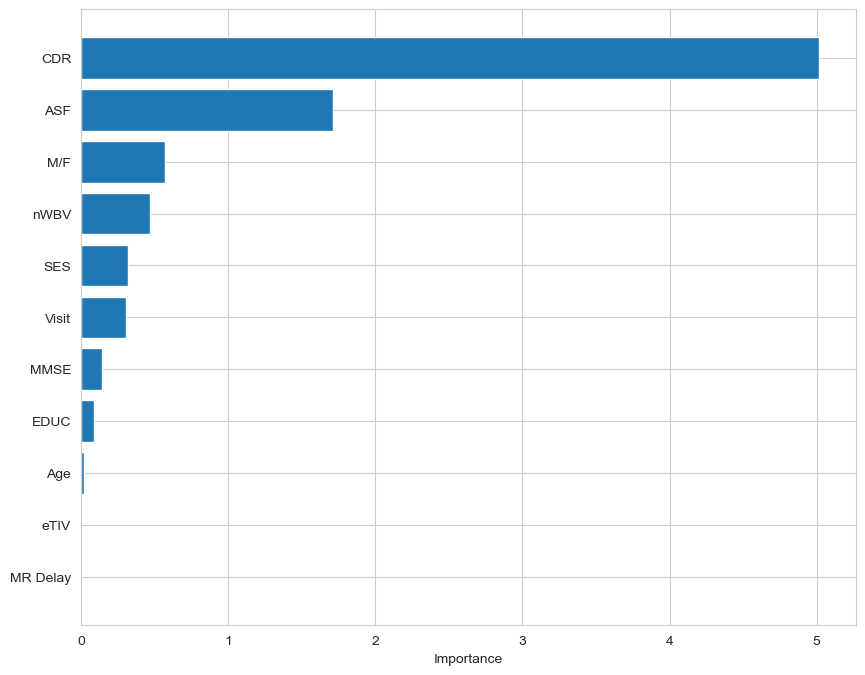

In [17]:
# Assuming encoded_x is a DataFrame and its columns are feature names
feature_names = encoded_x.columns.tolist()

# Get the coefficients
# This will be a 2D array in the case of multi-class, with one row per class
coefficients = best_model_lr.best_estimator_.coef_


# Handle multi-class by averaging the absolute values of coefficients across classes
avg_importance = np.mean(np.abs(coefficients), axis=0)

print(feature_names)
print(avg_importance)

# Sort feature importances
indices = np.argsort(avg_importance)

# Get sorted feature names
sorted_feature_names = [feature_names[i] for i in indices]

# Plot
plt.figure(figsize=(10, 8))

plt.barh(sorted_feature_names, avg_importance[indices], align="center")
plt.xlabel("Importance")
plt.savefig("logistical_regression_feature_importance_plot.png")
plt.show()


# Decision Tree Model



In [18]:
np.random.seed(0)

def model_param_selection(model, X, y, param_grid, nfolds):
    """Function to perform grid search."""
    
    # Set up the grid search
    grid_search = GridSearchCV(model, param_grid, cv=nfolds, verbose=10, n_jobs=-1)
    best_model = grid_search.fit(X, y)
    
    # Return the best parameters from the grid search
    return best_model, grid_search.best_params_, grid_search.best_score_

# Define the parameter values to be searched for Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'ccp_alpha': [0.0, 0.01, 0.05, 0.1]
}

Kfold = 5
model_dt = DecisionTreeClassifier(random_state=0)
best_model_dt, best_params_dt, acc_dt = model_param_selection(model_dt, encoded_x, encoded_y, param_grid_dt, Kfold)

std_dt = best_model_dt.cv_results_['std_test_score'][best_model_dt.best_index_]

print("Best Params: ", best_params_dt)
print("Best Score:", acc_dt)
print("Best Score std:", std_dt)


Fitting 5 folds for each of 25920 candidates, totalling 129600 fits
Best Params:  {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
Best Score: 0.9033873873873872
Best Score std: 0.020252252252252245


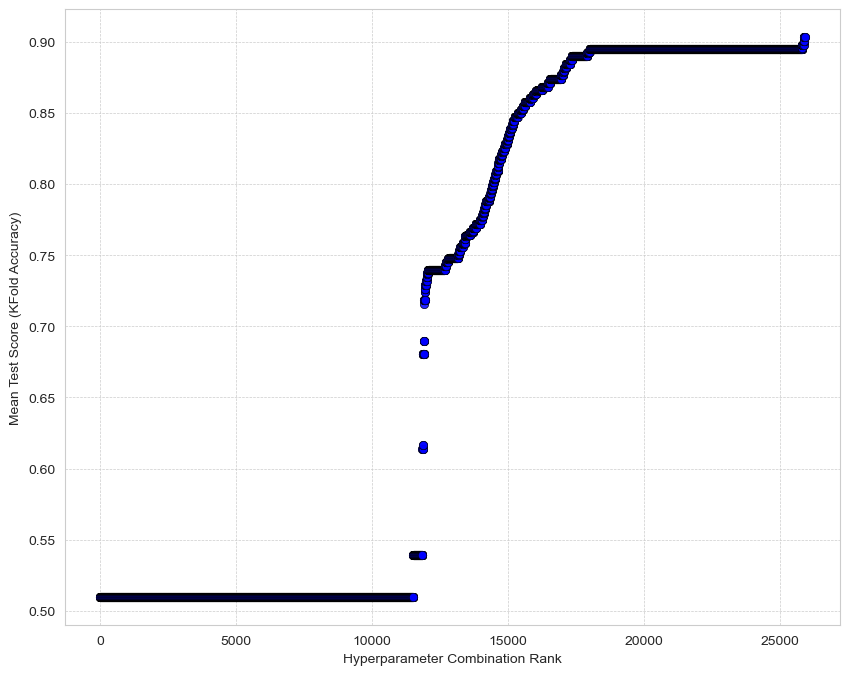

In [19]:
# Extract mean test scores
mean_test_scores = best_model_dt.cv_results_['mean_test_score']

# Sort the mean test scores in ascending order and get their indices
sorted_indices = np.argsort(mean_test_scores)
sorted_scores = mean_test_scores[sorted_indices]

# Create positions for each hyperparameter combination
positions = np.arange(len(sorted_scores))

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(positions, sorted_scores, color='blue', alpha=0.6, edgecolors="k", linewidth=0.5)
plt.xlabel('Hyperparameter Combination Rank')
plt.ylabel('Mean Test Score (KFold Accuracy)')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig("Decision_tree_scatter_plot.png")
plt.show()


In [20]:
# Extract all parameter sets for Decision Tree
params_sets_dt = best_model_dt.cv_results_['params']

# Extract mean test scores for Decision Tree
mean_test_scores_dt = best_model_dt.cv_results_['mean_test_score']

# Sort the mean test scores in ascending order and get their indices
sorted_indices_dt = np.argsort(mean_test_scores_dt)

# Get parameters and accuracy for lowest, medium, and highest kfold accuracy for Decision Tree
lowest_params_dt = params_sets_dt[sorted_indices_dt[0]]
middle_params_dt = params_sets_dt[sorted_indices_dt[len(sorted_indices_dt) // 2]]  # Choose the middle index
highest_params_dt = params_sets_dt[sorted_indices_dt[-1]]  # The last index corresponds to the best parameters
lowest_acc_dt = mean_test_scores_dt[sorted_indices_dt[0]]
middle_acc_dt = mean_test_scores_dt[sorted_indices_dt[len(sorted_indices_dt) // 2]]
highest_acc_dt = mean_test_scores_dt[sorted_indices_dt[-1]]

# Function to print the table for Decision Tree
def print_params_table_dt(lowest, middle, highest, lowest_acc, middle_acc, highest_acc):
    # Print the header
    print("{:<25} {:<25} {:<25} {:<25}".format('Parameter/Metric', 'Lowest', 'Middle', 'Highest'))
    print('-' * 100)
    
    # Print kfold accuracy values for Decision Tree
    print("{:<25} {:<25.5f} {:<25.5f} {:<25.5f}".format('KFold Accuracy', lowest_acc, middle_acc, highest_acc))
    print('-' * 100)
    
    # Print parameter values for Decision Tree
    for key in lowest:
        print("{:<25} {:<25} {:<25} {:<25}".format(key, str(lowest[key]), str(middle[key]), str(highest[key])))

print_params_table_dt(lowest_params_dt, middle_params_dt, highest_params_dt, lowest_acc_dt, middle_acc_dt, highest_acc_dt)


Parameter/Metric          Lowest                    Middle                    Highest                  
----------------------------------------------------------------------------------------------------
KFold Accuracy            0.50941                   0.74782                   0.90339                  
----------------------------------------------------------------------------------------------------
ccp_alpha                 0.01                      0.05                      0.0                      
criterion                 entropy                   entropy                   gini                     
max_depth                 20                        None                      20                       
max_features              log2                      log2                      None                     
max_leaf_nodes            30                        10                        10                       
min_impurity_decrease     0.2                       0.0               

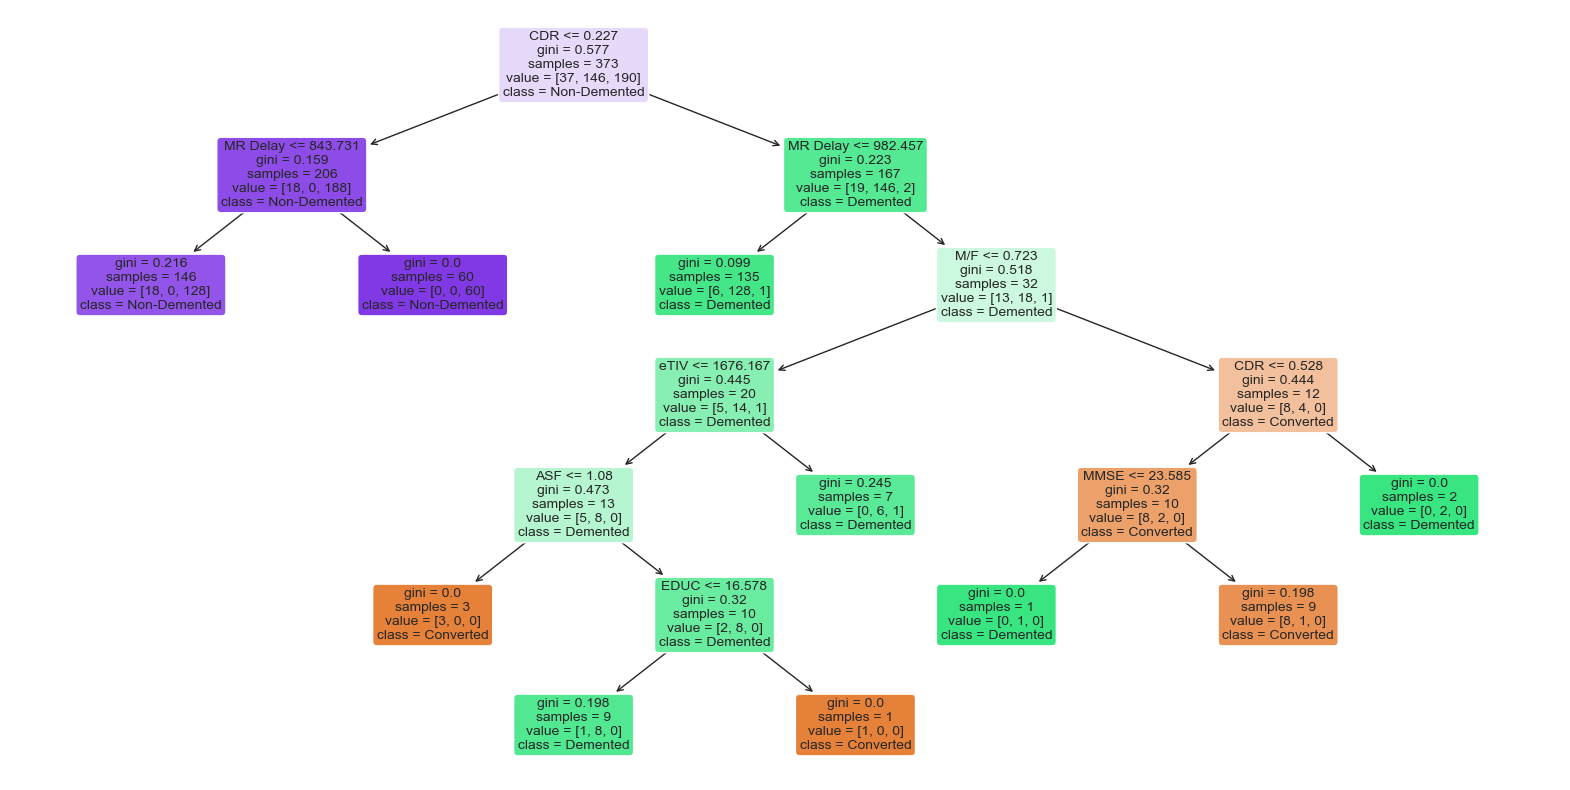

In [21]:
def plot_decision_tree_with_legend(model, feature_names, class_names):
    plt.figure(figsize=(20,10))  # Set the figure size
    plot_tree(model, feature_names=feature_names, filled=True, class_names=class_names, rounded=True, fontsize=10)
    
    # Creating a legend
    legend_elements = [Patch(facecolor=plt.cm.viridis(i/2), edgecolor='k', label=f"y[{i}] = {name}") for i, name in enumerate(class_names)]
#     plt.legend(handles=legend_elements, loc='upper right')
    
    plt.savefig("decision_tree_model.png")
    plt.show()

# Assuming encoded_x is a DataFrame with column names
feature_names = encoded_x.columns.tolist()
class_names = ['Converted', 'Demented', 'Non-Demented']

plot_decision_tree_with_legend(best_model_dt.best_estimator_, feature_names, class_names)


In [22]:
def print_tree_nodes_with_class(tree, feature_names, class_names):
    # Get tree properties
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    
    # Recursively print nodes
    def print_node(node, depth=0):
        indent = " " * depth
        if children_left[node] != children_right[node]:  # Internal node
            print(f"{indent}Node: depth {depth}, feature {feature_names[feature[node]]}, threshold {threshold[node]:.2f}")
            print_node(children_left[node], depth + 1)
            print_node(children_right[node], depth + 1)
        else:  # Leaf node
            values = tree.tree_.value[node][0]
            dominant_class = class_names[values.argmax()]
            print(f"{indent}Leaf: depth {depth}, value {values}, class: {dominant_class}")
    
    print_node(0)

# Assuming you've trained a decision tree called `best_model_dt`
print_tree_nodes_with_class(best_model_dt.best_estimator_, feature_names, class_names)


Node: depth 0, feature CDR, threshold 0.23
 Node: depth 1, feature MR Delay, threshold 843.73
  Leaf: depth 2, value [ 18.   0. 128.], class: Non-Demented
  Leaf: depth 2, value [ 0.  0. 60.], class: Non-Demented
 Node: depth 1, feature MR Delay, threshold 982.46
  Leaf: depth 2, value [  6. 128.   1.], class: Demented
  Node: depth 2, feature M/F, threshold 0.72
   Node: depth 3, feature eTIV, threshold 1676.17
    Node: depth 4, feature ASF, threshold 1.08
     Leaf: depth 5, value [3. 0. 0.], class: Converted
     Node: depth 5, feature EDUC, threshold 16.58
      Leaf: depth 6, value [1. 8. 0.], class: Demented
      Leaf: depth 6, value [1. 0. 0.], class: Converted
    Leaf: depth 4, value [0. 6. 1.], class: Demented
   Node: depth 3, feature CDR, threshold 0.53
    Node: depth 4, feature MMSE, threshold 23.59
     Leaf: depth 5, value [0. 1. 0.], class: Demented
     Leaf: depth 5, value [8. 1. 0.], class: Converted
    Leaf: depth 4, value [0. 2. 0.], class: Demented


['Visit', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
[0.         0.05169888 0.01409864 0.         0.00860883 0.
 0.00860883 0.89285894 0.00624599 0.         0.01787988]


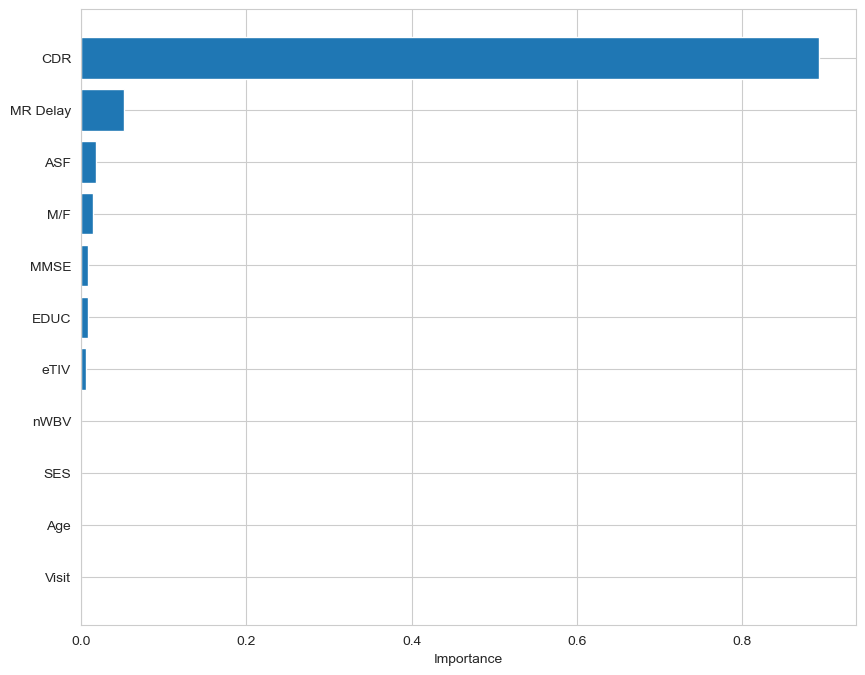

In [23]:
# Assuming encoded_x is a DataFrame and its columns are feature names
feature_names = encoded_x.columns.tolist()

# Get the feature importances
importances = best_model_dt.best_estimator_.feature_importances_
print(feature_names)
print(importances)

# Sort feature importances
indices = np.argsort(importances)

# Get sorted feature names
sorted_feature_names = [feature_names[i] for i in indices]

# Plot
plt.figure(figsize=(10, 8))

plt.barh(sorted_feature_names, importances[indices], align="center")
plt.xlabel("Importance")
plt.savefig("Decision_tree_feature_importance_plot.png")
plt.show()


# SVM Model


In [24]:
np.random.seed(0)

def svc_param_selection(X, y, nfolds):
    """Function to perform grid search on SVC."""
    
    # Define the parameter values to be searched
    param_grid = {
        'C': [0.1, 1, 10],  # example range for C
        'gamma': ['auto'],  # example range for gamma
        'kernel': ['linear','poly', 'rbf', 'sigmoid'],  # example kernels
        'degree': [2]  # example degrees for poly kernel
    }
    
    # Set up the grid search with SVC and the parameter grid
    grid_search = GridSearchCV(SVC(tol=1e-3, random_state=0), param_grid, cv=nfolds, verbose=10, n_jobs=1)
    best_model = grid_search.fit(X, y)
    
    # Return the best parameters from the grid search
    return best_model, grid_search.best_params_ , grid_search.best_score_, grid_search.error_score

# Example usage:
Kfold = 5
model_svc, best_params, acc_svc, _ = svc_param_selection(encoded_x, encoded_y, Kfold)
std_svc = model_svc.cv_results_['std_test_score'][model_svc.best_index_]
print("Best Params: ", best_params)
print("Best Score:", acc_svc)
print("Best Score std:", std_svc)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START C=0.1, degree=2, gamma=auto, kernel=linear.................
[CV 1/5; 1/12] END C=0.1, degree=2, gamma=auto, kernel=linear;, score=0.880 total time=   8.5s
[CV 2/5; 1/12] START C=0.1, degree=2, gamma=auto, kernel=linear.................
[CV 2/5; 1/12] END C=0.1, degree=2, gamma=auto, kernel=linear;, score=0.853 total time=   5.4s
[CV 3/5; 1/12] START C=0.1, degree=2, gamma=auto, kernel=linear.................
[CV 3/5; 1/12] END C=0.1, degree=2, gamma=auto, kernel=linear;, score=0.827 total time=   5.4s
[CV 4/5; 1/12] START C=0.1, degree=2, gamma=auto, kernel=linear.................
[CV 4/5; 1/12] END C=0.1, degree=2, gamma=auto, kernel=linear;, score=0.838 total time=   2.6s
[CV 5/5; 1/12] START C=0.1, degree=2, gamma=auto, kernel=linear.................
[CV 5/5; 1/12] END C=0.1, degree=2, gamma=auto, kernel=linear;, score=0.838 total time=   3.2s
[CV 1/5; 2/12] START C=0.1, degree=2, gamma=auto, kernel=po

[CV 3/5; 10/12] END C=10, degree=2, gamma=auto, kernel=poly;, score=0.880 total time= 4.9min
[CV 4/5; 10/12] START C=10, degree=2, gamma=auto, kernel=poly...................
[CV 4/5; 10/12] END C=10, degree=2, gamma=auto, kernel=poly;, score=0.811 total time= 2.7min
[CV 5/5; 10/12] START C=10, degree=2, gamma=auto, kernel=poly...................
[CV 5/5; 10/12] END C=10, degree=2, gamma=auto, kernel=poly;, score=0.838 total time= 3.1min
[CV 1/5; 11/12] START C=10, degree=2, gamma=auto, kernel=rbf....................
[CV 1/5; 11/12] END C=10, degree=2, gamma=auto, kernel=rbf;, score=0.533 total time=   0.0s
[CV 2/5; 11/12] START C=10, degree=2, gamma=auto, kernel=rbf....................
[CV 2/5; 11/12] END C=10, degree=2, gamma=auto, kernel=rbf;, score=0.480 total time=   0.0s
[CV 3/5; 11/12] START C=10, degree=2, gamma=auto, kernel=rbf....................
[CV 3/5; 11/12] END C=10, degree=2, gamma=auto, kernel=rbf;, score=0.533 total time=   0.0s
[CV 4/5; 11/12] START C=10, degree=2, ga

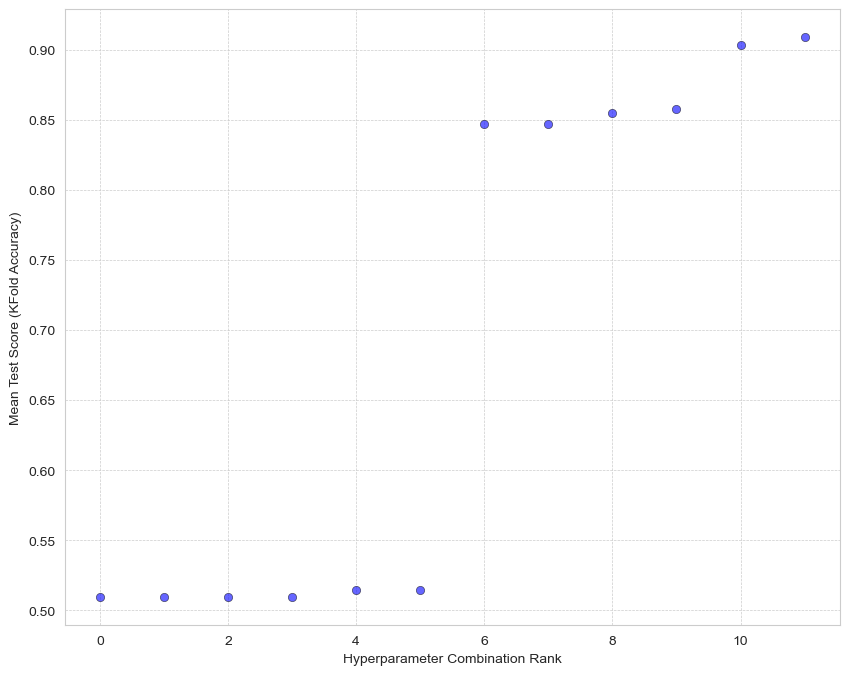

In [25]:
# Extract mean test scores
mean_test_scores = model_svc.cv_results_['mean_test_score']

# Sort the mean test scores in ascending order and get their indices
sorted_indices = np.argsort(mean_test_scores)
sorted_scores = mean_test_scores[sorted_indices]

# Create positions for each hyperparameter combination
positions = np.arange(len(sorted_scores))

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(positions, sorted_scores, color='blue', alpha=0.6, edgecolors="k", linewidth=0.5)
plt.xlabel('Hyperparameter Combination Rank')
plt.ylabel('Mean Test Score (KFold Accuracy)')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig("SVM_scatter_plot.png")
plt.show()


In [26]:
# Extract all parameter sets for SVC
params_sets_svc = model_svc.cv_results_['params']

# Extract mean test scores for SVC
mean_test_scores_svc = model_svc.cv_results_['mean_test_score']

# Sort the mean test scores in ascending order and get their indices
sorted_indices_svc = np.argsort(mean_test_scores_svc)

# Get parameters and accuracy for lowest, medium, and highest kfold accuracy for SVC
lowest_params_svc = params_sets_svc[sorted_indices_svc[0]]
middle_params_svc = params_sets_svc[sorted_indices_svc[len(sorted_indices_svc) // 2]]  # Choose the middle index
highest_params_svc = params_sets_svc[sorted_indices_svc[-1]]  # The last index corresponds to the best parameters
lowest_acc_svc = mean_test_scores_svc[sorted_indices_svc[0]]
middle_acc_svc = mean_test_scores_svc[sorted_indices_svc[len(sorted_indices_svc) // 2]]
highest_acc_svc = mean_test_scores_svc[sorted_indices_svc[-1]]

# Function to print the table for SVC
def print_params_table_svc(lowest, middle, highest, lowest_acc, middle_acc, highest_acc):
    # Print the header
    print("{:<25} {:<25} {:<25} {:<25}".format('Parameter/Metric', 'Lowest', 'Middle', 'Highest'))
    print('-' * 100)
    
    # Print kfold accuracy values for SVC
    print("{:<25} {:<25.5f} {:<25.5f} {:<25.5f}".format('KFold Accuracy', lowest_acc, middle_acc, highest_acc))
    print('-' * 100)
    
    # Print parameter values for SVC
    for key in lowest:
        print("{:<25} {:<25} {:<25} {:<25}".format(key, str(lowest[key]), str(middle[key]), str(highest[key])))

print_params_table_svc(lowest_params_svc, middle_params_svc, highest_params_svc, lowest_acc_svc, middle_acc_svc, highest_acc_svc)


Parameter/Metric          Lowest                    Middle                    Highest                  
----------------------------------------------------------------------------------------------------
KFold Accuracy            0.50941                   0.84706                   0.90897                  
----------------------------------------------------------------------------------------------------
C                         0.1                       10                        1                        
degree                    2                         2                         2                        
gamma                     auto                      auto                      auto                     
kernel                    rbf                       poly                      linear                   


['Visit', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
[0.         0.05169888 0.01409864 0.         0.00860883 0.
 0.00860883 0.89285894 0.00624599 0.         0.01787988]


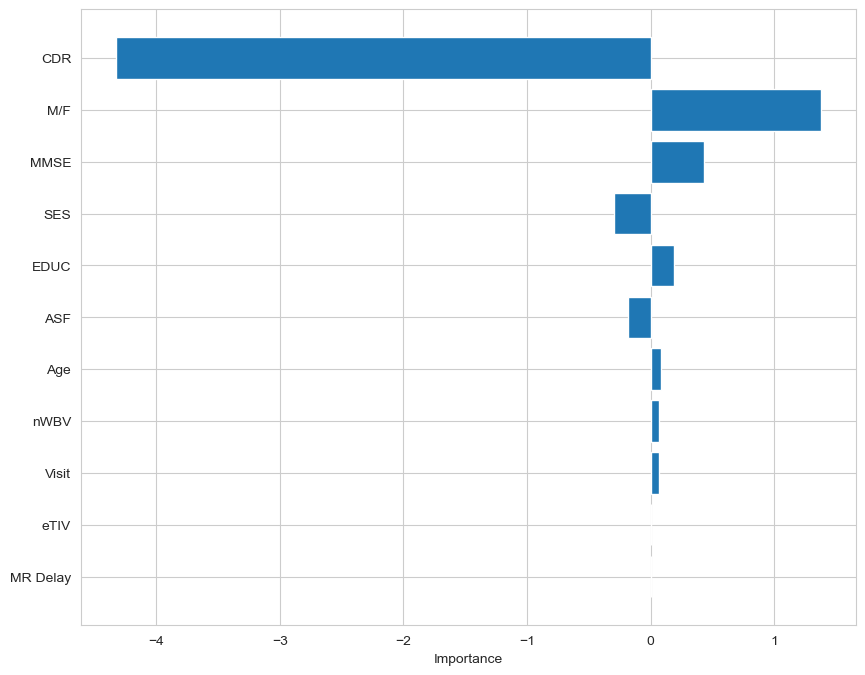

In [27]:
# Assuming encoded_x is a DataFrame and columns are feature names
feature_names = encoded_x.columns.tolist()

if best_params['kernel'] == 'linear':
    # Retrieve feature importances (or coefficients) for linear SVC
    importance = model_svc.best_estimator_.coef_[0]
    print(feature_names)
    print(importances)
    # Sort feature importances
    indices = np.argsort(np.abs(importance))

    # Get sorted feature names
    sorted_feature_names = [feature_names[i] for i in indices]

    # Plot the feature importances of the SVC model
    plt.figure(figsize=(10, 8))
#     plt.title("Feature importances (coefficients) for Linear SVC")
    plt.barh(sorted_feature_names, importance[indices], align="center")
    plt.xlabel("Importance")
    
    plt.savefig("SVM_feature_importance_plot.png")
    plt.show()

else:
    print("Feature importance is not directly interpretable for non-linear kernels.")


# Comparison of the models' accuracies

Model Accuracies: ['0.908973', '0.908901', '0.903387', '0.914306']
Standard Deviations: ['0.022607', '0.012793', '0.020252', '0.019670']


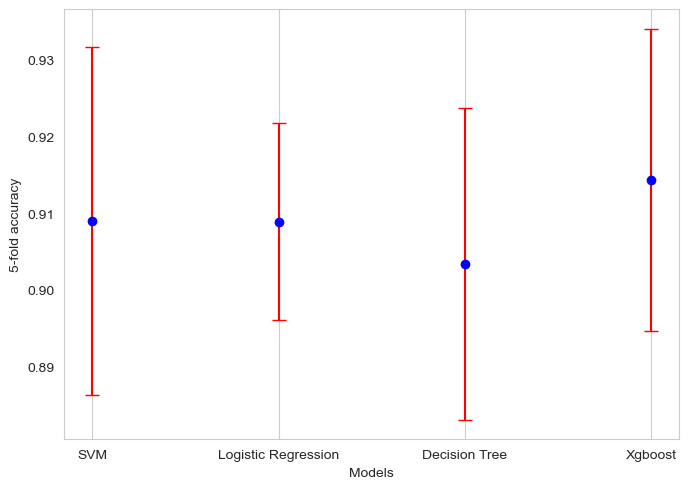

In [28]:
model_names = ['SVM', 'Logistic Regression', 'Decision Tree', 'Xgboost']
model_accuracies = [acc_svc, acc_lr, acc_dt, acc_xgb]
std_dev = [std_svc, std_lr, std_dt, std_xgb]  # standard deviations for all four models
# Format and print model accuracies
formatted_accuracies = ["{:.6f}".format(acc) for acc in model_accuracies]
print("Model Accuracies:", formatted_accuracies)

# Format and print standard deviations
formatted_std_dev = ["{:.6f}".format(std) for std in std_dev]
print("Standard Deviations:", formatted_std_dev)


fig = plt.figure(figsize=(7, 5))

# creating the point plot with error bars
plt.errorbar(model_names, model_accuracies, yerr=std_dev, fmt='o', capsize=5, color='blue', ecolor='red', elinewidth=1.5)

plt.xlabel("Models")
plt.ylabel("5-fold accuracy")

plt.grid(axis='y')  # Add a grid for better readability
plt.tight_layout()  # Adjust the layout for better appearance
plt.savefig("model_comparison_plot.png")
plt.show()


Accuracies for SVM:
	Lowest Accuracy: 0.509405
	Middle Accuracy: 0.847063
	Highest Accuracy: 0.908973

Accuracies for Logistic Regression:
	Lowest Accuracy: 0.490775
	Middle Accuracy: 0.686306
	Highest Accuracy: 0.908901

Accuracies for Decision Tree:
	Lowest Accuracy: 0.509405
	Middle Accuracy: 0.747820
	Highest Accuracy: 0.903387

Accuracies for Xgboost:
	Lowest Accuracy: 0.881946
	Middle Accuracy: 0.898162
	Highest Accuracy: 0.914306



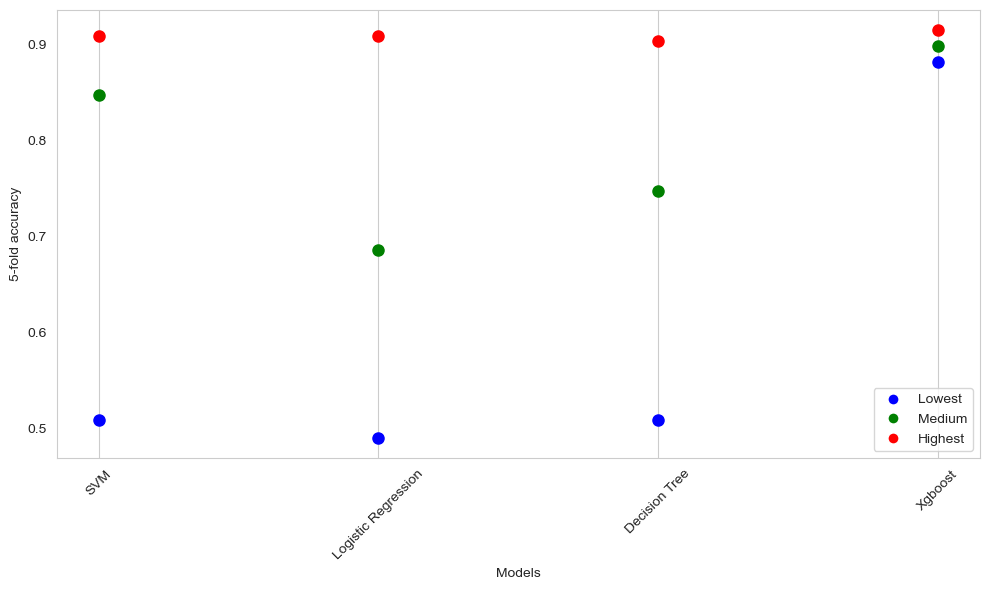

In [29]:
# Example data (replace with your actual data)
model_names = ['SVM', 'Logistic Regression', 'Decision Tree', 'Xgboost']
accuracy_levels = ['Lowest', 'Medium', 'Highest']
accuracy_colors = ['blue', 'green', 'red']

lowest_acc = [lowest_acc_svc, lowest_acc_lr, lowest_acc_dt, lowest_acc_xgb]
middle_acc = [middle_acc_svc, middle_acc_lr, middle_acc_dt, middle_acc_xgb]
highest_acc = [highest_acc_svc, highest_acc_lr, highest_acc_dt, highest_acc_xgb]
# Printing formatted accuracies for each model
for idx, model in enumerate(model_names):
    print(f"Accuracies for {model}:")
    print("\tLowest Accuracy:", "{:.6f}".format(lowest_acc[idx]))
    print("\tMiddle Accuracy:", "{:.6f}".format(middle_acc[idx]))
    print("\tHighest Accuracy:", "{:.6f}".format(highest_acc[idx]))
    print()


fig, ax = plt.subplots(figsize=(10, 6))

# Plot the range between lowest, medium, and highest accuracies for each algorithm
for i, model_name in enumerate(model_names):
    accuracies = [lowest_acc[i], middle_acc[i], highest_acc[i]]
    for j, level in enumerate(accuracy_levels):
        ax.plot([model_name], accuracies[j], marker='o', color=accuracy_colors[j], linestyle='', markersize=8)

ax.set_xlabel("Models")
ax.set_ylabel("5-fold accuracy")

ax.grid(axis='y')

# Create a single legend outside of the loop
legend_elements = [Line2D([0], [0], marker='o', color='w', label=level, markersize=8, markerfacecolor=color) for level, color in zip(accuracy_levels, accuracy_colors)]
ax.legend(handles=legend_elements)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("model_comparison_range_plot.png")
plt.show()


In [30]:
import pandas as pd

# Collect the best parameters and scores for all algorithms
algorithm_names = ['SVM', 'Logistic Regression', 'Decision Tree', 'Xgboost']
best_params_compare = [best_params, best_params_lr, best_params_dt, best_params_xgb]
best_scores_compare = [acc_svc, acc_lr, acc_dt, acc_xgb]

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Algorithm': algorithm_names, 'Best Parameters': best_params_compare, 'Best Score': best_scores_compare})

# Set option to display all parameters without truncation
pd.set_option('display.max_colwidth', None)

# Print the results
print(results_df)


             Algorithm  \
0                  SVM   
1  Logistic Regression   
2        Decision Tree   
3              Xgboost   

                                                                                                                                                                                              Best Parameters  \
0                                                                                                                                                  {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}   
1                                                                                                                             {'C': 5, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.0001}   
2  {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}   
3                                